<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EC%8B%9D_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 삼성전자 주식 예측

### 데이터 불러오기

In [119]:
# 필요 모듈 설치
!pip install finance-datareader
!pip install opendartreader
!pip install --upgrade opendartreader

In [120]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 주식가격 로딩
import FinanceDataReader as fdr

# 재무재표 로딩
import OpenDartReader

## EDA

### 주식 EDA

In [121]:
import datetime

In [122]:
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = '005930'
stock = fdr.DataReader( sample_code, start = start_date, end = end_date )
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
...,...,...,...,...,...,...
2021-09-01,76700,77100,75900,76800,16114775,0.001304
2021-09-02,76800,76800,75700,76000,15347486,-0.010417
2021-09-03,76400,76700,76000,76600,12096419,0.007895


Text(0, 0.5, 'price')

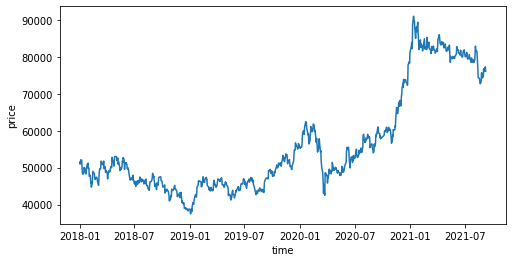

In [123]:
plt.figure(figsize=(8, 4))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

### 거래량과 종가 간의 관계 확인

In [124]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919


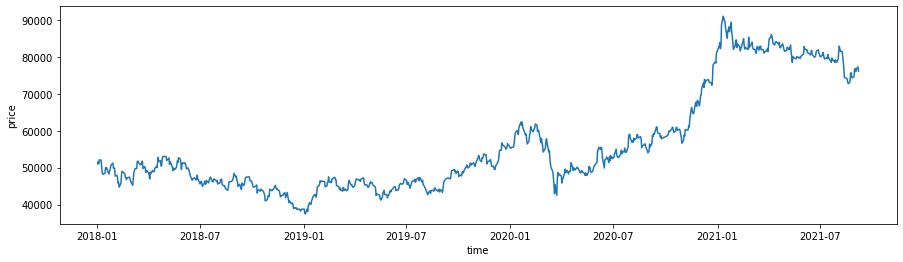

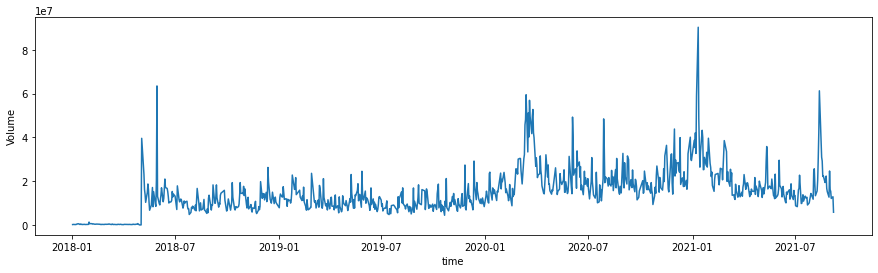

In [125]:
plt.figure(figsize=(15, 4))
sns.lineplot(y=stock['Close'], x=stock.index) # 시간에 따른 종가 변화
plt.xlabel('time')
plt.ylabel('price')

plt.figure(figsize=(15, 4))
sns.lineplot(y=stock['Volume'], x=stock.index)  # 시간에 따른 거래량 변화
plt.xlabel('time')
plt.ylabel('Volume')
plt.show()

In [126]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(MinMaxScaler().fit_transform(stock))
df.columns = list(stock.columns)

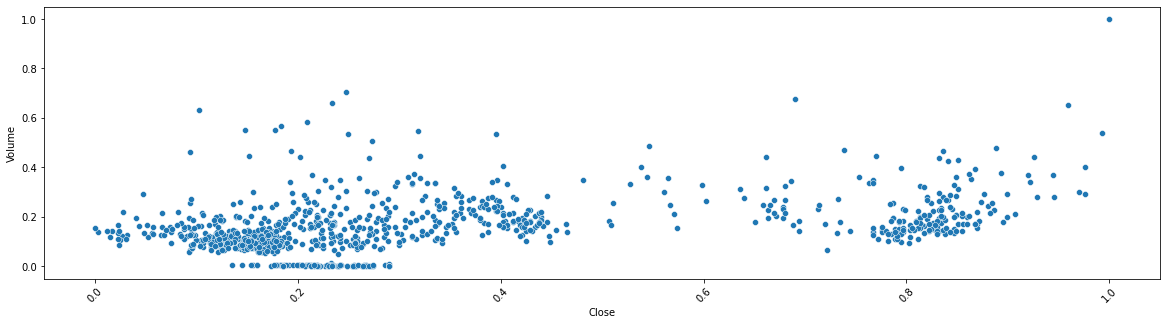

In [127]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df, x='Close', y='Volume') # 상관성은 거의 없어보임..
plt.xticks(rotation=45)
plt.show()

#### 2018년 거래량 증폭
- https://www.yna.co.kr/view/AKR20180504037752008
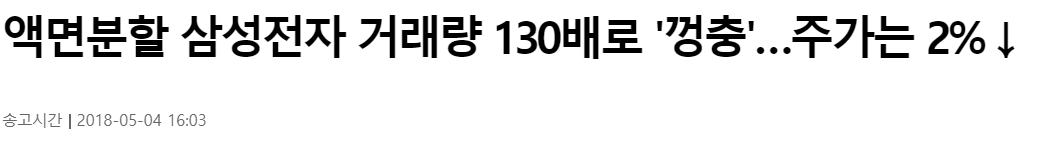

In [128]:
# 2018이후 거래량이 증가 
stock[stock.index >= '2018-04-25'].head(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-04-25,49220,50500,49220,50400,332292,-0.001189
2018-04-26,50420,52160,50400,52140,360931,0.034524
2018-04-27,53380,53639,52440,53000,606216,0.016494
2018-04-30,0,0,0,53000,0,0.000000
2018-05-02,0,0,0,53000,0,0.000000
2018-05-03,0,0,0,53000,0,0.000000
2018-05-04,53000,53900,51800,51900,39565391,-0.020755
2018-05-08,52600,53200,51900,52600,23104720,0.013487
2018-05-09,52600,52800,50900,50900,16128305,-0.032319


 - 거래량의 차이가 있어 분석에 영향을 줄수 있으므로 분석기간을 2018년 5월 4일 이후 데이터를 사용하여 분석을 진행

 - 두 연속형변수간의 상관성을 파악하기 위해서 피어슨 상관계수를 활용

In [129]:
stock_re = stock[stock.index >= '2018-05-04']

In [130]:
stock_re.corr()['Close'].sort_values(ascending = False)[1:]

High      0.999289
Low       0.999214
Open      0.998420
Volume    0.367400
Change    0.044145
Name: Close, dtype: float64

- Close - Volume 의 피어슨 상관계수는 0.374137 로 약한 양의 상관성이 있는 것으로 보인다. 하지만 이것만으로 Close를 예측하는 것은 무리가 있어 보인다.

#### 주식 가격의 변동율을 통해서 가격등락 예측
- 시계열 정상성을 성립을 위해서

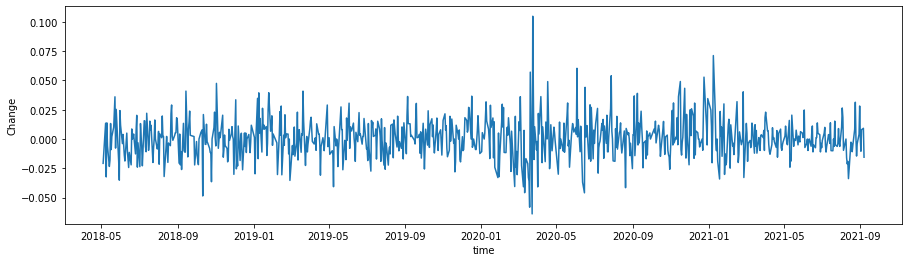

In [131]:
plt.figure(figsize=(15, 4))
sns.lineplot(y=stock_re['Change'], x=stock_re.index)
plt.xlabel('time')
plt.ylabel('Change')
plt.show()

In [132]:
import numpy as np

In [133]:
stock_re['Change'].quantile(0.75)

0.009977827050997812

In [134]:
stock_re['UD'] = np.where(stock_re['Change'] > stock_re['Change'].quantile(0.75), 1, np.where(stock_re['Change'] < stock_re['Change'].quantile(0.25), -1, 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [135]:
stock_re.UD.value_counts()

 0    413
 1    206
-1    206
Name: UD, dtype: int64

In [136]:
stock_re.head()

,Open,High,Low,Close,Volume,Change,UD
Date,,,,,,,
2018-05-04,53000,53900,51800,51900,39565391,-0.020755,-1
2018-05-08,52600,53200,51900,52600,23104720,0.013487,1
2018-05-09,52600,52800,50900,50900,16128305,-0.032319,-1
2018-05-10,51700,51700,50600,51600,13905263,0.013752,1
2018-05-11,52000,52200,51200,51300,10314997,-0.005814,0


## LSTM - Classification

### 데이터 전처리

In [137]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'UD']
# 스케일 후 columns
scaled = scaler.fit_transform(stock_re[scale_cols])
scaled

array([[0.29422895, 0.27533784, 0.28395062, ..., 0.40930157, 0.25579124,
        0.        ],
       [0.28666036, 0.26351351, 0.28584995, ..., 0.21767481, 0.45890951,
        1.        ],
       [0.28666036, 0.25675676, 0.2668566 , ..., 0.13645893, 0.18719175,
        0.        ],
       ...,
       [0.73699149, 0.66047297, 0.74358974, ..., 0.08952177, 0.42573443,
        0.5       ],
       [0.74456008, 0.67567568, 0.75498575, ..., 0.09842472, 0.43311149,
        0.5       ],
       [0.75023652, 0.66722973, 0.74358974, ..., 0.01617671, 0.28681927,
        0.        ]])

In [138]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [139]:
df.head()

,Open,High,Low,Close,Volume,Change,UD
0,0.294229,0.275338,0.283951,0.269841,0.409302,0.255791,0.0
1,0.286660,0.263514,0.285850,0.282913,0.217675,0.458910,1.0
2,0.286660,0.256757,0.266857,0.251167,0.136459,0.187192,0.0
3,0.269631,0.238176,0.261159,0.264239,0.110579,0.460481,1.0
4,0.275307,0.246622,0.272555,0.258637,0.068783,0.344417,0.5


### train / test 분할

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('UD', 1), df['UD'], test_size=0.2, random_state=0, shuffle=False)

In [142]:
x_train.shape, y_train.shape

((660, 6), (660,))

In [143]:
x_test.shape, y_test.shape

((165, 6), (165,))

In [144]:
import tensorflow as tf

In [145]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

In [146]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [147]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, feature갯수): (32, 1)


#### 모델

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation='softmax'),
    Dense(1),
])

# model.add(LSTM(64,
#                input_shape = (None, 1),
#                return_sequences= True))
# model.add(LSTM(64,
#                input_shape = (None, 1),
#                return_sequences = False))
# model.add(Dense(32, activation = 'tanh'))
# model.add(Dense(1, activation = 'softmax'))


In [149]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 20, 32)            192       
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [150]:
optimizer = Adam(0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [151]:
# earlystopping은 10번 epoch동안 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max',
                              patience = 50,
                              verbose = 1)
# 체크포인터도 생성합니다.
checkpoint = ModelCheckpoint('best.h5',
                             monitor='val_accuracy',
                             mode = 'max',
                             save_best_only = True, 
                             verbose=1)

In [152]:
history = model.fit(train_data,
                    epochs=1000, 
                    batch_size = 1,
                    validation_data=(test_data), 
                    callbacks=[checkpoint, earlystopping],
                    verbose=1)

Epoch 1/1000
20/20 [==============================] - 3s 42ms/step - loss: 6.0443e-08 - accuracy: 0.2547 - val_loss: 5.6316e-08 - val_accuracy: 0.1931

Epoch 00001: val_accuracy improved from -inf to 0.19310, saving model to best.h5
Epoch 2/1000
20/20 [==============================] - 0s 12ms/step - loss: 6.0443e-08 - accuracy: 0.2547 - val_loss: 5.6316e-08 - val_accuracy: 0.1931

Epoch 00002: val_accuracy did not improve from 0.19310
Epoch 3/1000
20/20 [==============================] - 0s 12ms/step - loss: 6.0443e-08 - accuracy: 0.2547 - val_loss: 5.6316e-08 - val_accuracy: 0.1931

Epoch 00003: val_accuracy did not improve from 0.19310
Epoch 4/1000
20/20 [==============================] - 0s 12ms/step - loss: 6.0443e-08 - accuracy: 0.2547 - val_loss: 5.6316e-08 - val_accuracy: 0.1931

Epoch 00004: val_accuracy did not improve from 0.19310
Epoch 5/1000
20/20 [==============================] - 0s 12ms/step - loss: 6.0443e-08 - accuracy: 0.2547 - val_loss: 5.6316e-08 - val_accuracy: 0.

In [153]:
model.load_weights('best.h5')

In [154]:
pred = model.predict(test_data)

In [155]:
print(test_data.take(1))

<TakeDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [156]:
pred.shape

(145, 1)

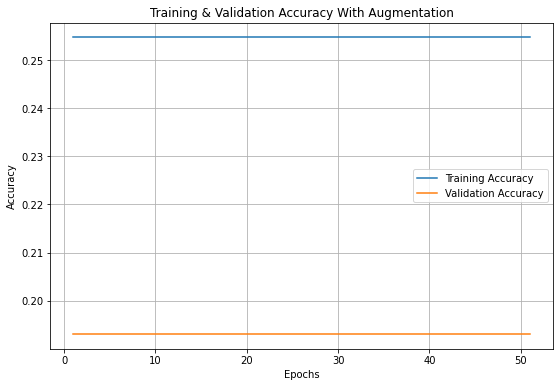

In [157]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize = (9, 6))
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Training & Validation Accuracy With Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 종가 예측
- 데이터의 정상성 가정..

In [158]:
df.head()

,Open,High,Low,Close,Volume,Change,UD
0,0.294229,0.275338,0.283951,0.269841,0.409302,0.255791,0.0
1,0.286660,0.263514,0.285850,0.282913,0.217675,0.458910,1.0
2,0.286660,0.256757,0.266857,0.251167,0.136459,0.187192,0.0
3,0.269631,0.238176,0.261159,0.264239,0.110579,0.460481,1.0
4,0.275307,0.246622,0.272555,0.258637,0.068783,0.344417,0.5


In [159]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Close','UD'], 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [160]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### 모델

In [161]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [162]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [163]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [164]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
20/20 [==============================] - 3s 38ms/step - loss: 0.0389 - mse: 0.0778 - val_loss: 0.2761 - val_mse: 0.5523

Epoch 00001: val_loss improved from inf to 0.27613, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0217 - mse: 0.0433 - val_loss: 0.1167 - val_mse: 0.2334

Epoch 00002: val_loss improved from 0.27613 to 0.11672, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0049 - mse: 0.0099 - val_loss: 0.0150 - val_mse: 0.0299

Epoch 00003: val_loss improved from 0.11672 to 0.01495, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0028 - mse: 0.0057 - val_loss: 0.0135 - val_mse: 0.0269

Epoch 00004: val_loss improved from 0.01495 to 0.01345, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0018 - mse: 0.0036 - val_

In [165]:
model.load_weights(filename)

In [166]:
pred = model.predict(test_data)

In [167]:
pred.shape

(145, 1)

In [168]:
pred

array([[0.8510066 ],
       [0.84753346],
       [0.84313506],
       [0.8416809 ],
       [0.83985895],
       [0.83738977],
       [0.8359474 ],
       [0.8366544 ],
       [0.8356201 ],
       [0.8329971 ],
       [0.8300946 ],
       [0.8301911 ],
       [0.8279363 ],
       [0.8286131 ],
       [0.83006155],
       [0.8314931 ],
       [0.8308367 ],
       [0.8307743 ],
       [0.82964593],
       [0.8268838 ],
       [0.82494384],
       [0.82318944],
       [0.82098776],
       [0.8204115 ],
       [0.8203518 ],
       [0.82122016],
       [0.82080746],
       [0.8213869 ],
       [0.8211122 ],
       [0.82036895],
       [0.81905454],
       [0.81755376],
       [0.81609   ],
       [0.8148648 ],
       [0.8137576 ],
       [0.8145685 ],
       [0.81637394],
       [0.818828  ],
       [0.82238966],
       [0.82767737],
       [0.8332542 ],
       [0.83749276],
       [0.8405454 ],
       [0.84210956],
       [0.84197533],
       [0.8414156 ],
       [0.8412813 ],
       [0.841

### 결과 그래프

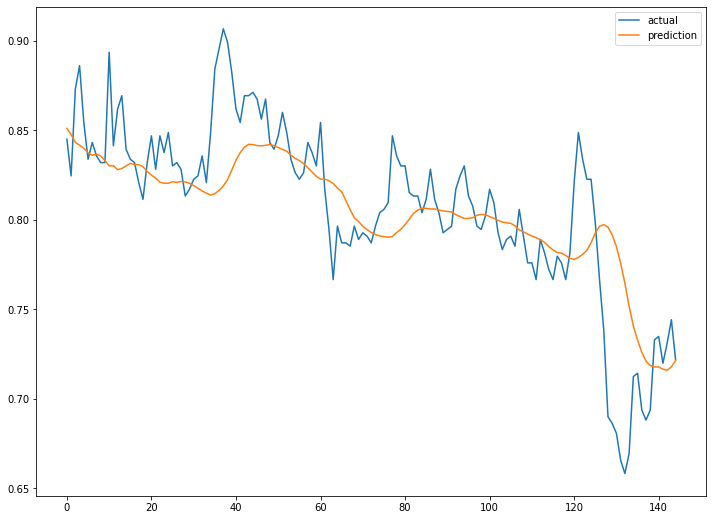

In [169]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

## 재무정보 추가

### 재무정보

- PER : 주가를 1주당 순이익(EPS)로 나눈 값
- PBR : 주가를 1주당 순자산가치로 나눈 값
- ROE : 당기순이익을 순자산(자기자본)으로 나눈 값
- ROA : 당기순이익을 자산총액으로 나눈 값

- 주가, 당기 순이익, 총발행 주식수, 자복, 부채

In [170]:
api_key = '9b9157d4313a84f3141d73f879c5d239d49bb0ce'
dart = OpenDartReader(api_key)

#### 자본, 자산, 당기순이익 조회
corp: 종목코드, bsns_year: 사업연도, reprt_code: 보고서코드
- (1분기보고서 : 11013, 반기보고서 : 11012, 3분기보고서 : 11014, 사업보고서 : 11011)

자본과 자산(자본+부채)은 재무상태표(sj_vis='BIS'), 당기순이익은 포괄손익계산서(sj_div='CIS')에서 확인할 수 있다.

In [171]:
fs_2019 = dart.finstate_all(corp='005930', bsns_year='2019', fs_div='CFS', reprt_code=11011) 
fs_2020_3Q = dart.finstate_all(corp='005930', bsns_year='2020', fs_div='CFS', reprt_code=11014)

fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['BS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_Equity']), ]

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
52,20201116001248,11014,2020,00126380,BS,재무상태표,ifrs-full_Equity,자본총계,-,제 52 기 3분기말,276136188000000,제 51 기말,262880421000000,55,NaN,NaN,NaN,NaN


In [172]:
fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['BS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_Liabilities']), ]

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
42,20201116001248,11014,2020,00126380,BS,재무상태표,ifrs-full_Liabilities,부채총계,-,제 52 기 3분기말,99652554000000,제 51 기말,89684076000000,44,NaN,NaN,NaN,NaN


In [173]:
fs = dart.finstate_all(corp='005930', bsns_year = '2019')

In [174]:
len(fs[fs.bsns_year == '2020'])

0

In [175]:
fs.loc[fs['sj_div'].isin(['BS']) & fs['account_id'].isin(['ifrs-full_Equity']), ]

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,bfefrmtrm_nm,bfefrmtrm_amount,ord,thstrm_add_amount
53,20200330003851,11011,2019,00126380,BS,재무상태표,ifrs-full_Equity,자본총계,-,제 51 기,262880421000000,제 50 기,247753177000000,제 49 기,214491428000000,56,NaN


## LSTM - Regression

### 전처리

In [176]:
# 전처리

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols_2 = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
# 스케일 후 columns
scaled_2 = scaler.fit_transform(stock_re[scale_cols_2])
scaled_2

array([[0.29422895, 0.27533784, 0.28395062, 0.26984127, 0.40930157,
        0.25579124],
       [0.28666036, 0.26351351, 0.28584995, 0.28291317, 0.21767481,
        0.45890951],
       [0.28666036, 0.25675676, 0.2668566 , 0.25116713, 0.13645893,
        0.18719175],
       ...,
       [0.73699149, 0.66047297, 0.74358974, 0.73109244, 0.08952177,
        0.42573443],
       [0.74456008, 0.67567568, 0.75498575, 0.74416433, 0.09842472,
        0.43311149],
       [0.75023652, 0.66722973, 0.74358974, 0.72175537, 0.01617671,
        0.28681927]])

In [177]:
df_2 = pd.DataFrame(scaled_2, columns=scale_cols_2)
df_2

,Open,High,Low,Close,Volume,Change
0,0.294229,0.275338,0.283951,0.269841,0.409302,0.255791
1,0.286660,0.263514,0.285850,0.282913,0.217675,0.458910
2,0.286660,0.256757,0.266857,0.251167,0.136459,0.187192
3,0.269631,0.238176,0.261159,0.264239,0.110579,0.460481
4,0.275307,0.246622,0.272555,0.258637,0.068783,0.344417
...,...,...,...,...,...,...
820,0.742668,0.667230,0.741690,0.734827,0.136301,0.386638
821,0.744560,0.662162,0.737892,0.719888,0.127369,0.317115
822,0.736991,0.660473,0.743590,0.731092,0.089522,0.425734
823,0.744560,0.675676,0.754986,0.744164,0.098425,0.433111


### train / test 분할

In [178]:
x_train, x_test, y_train, y_test = train_test_split(df_2.drop('Change', 1), df['Change'], test_size=0.2, random_state=0, shuffle=False)

In [179]:
x_train.shape, y_train.shape

((660, 5), (660,))

In [180]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [181]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### 모델

In [182]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [183]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [184]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 20, 32)            192       
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [185]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = 'best5_re.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [186]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
20/20 [==============================] - 3s 43ms/step - loss: 0.0658 - mse: 0.1317 - val_loss: 0.0378 - val_mse: 0.0755

Epoch 00001: val_loss improved from inf to 0.03777, saving model to best5_re.h5
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0230 - mse: 0.0460 - val_loss: 0.0032 - val_mse: 0.0063

Epoch 00002: val_loss improved from 0.03777 to 0.00316, saving model to best5_re.h5
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0064 - mse: 0.0127 - val_loss: 0.0028 - val_mse: 0.0056

Epoch 00003: val_loss improved from 0.00316 to 0.00281, saving model to best5_re.h5
Epoch 4/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0113 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00004: val_loss improved from 0.00281 to 0.00251, saving model to best5_re.h5
Epoch 5/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0056 - mse: 0.0112 - val_loss: 0.0025 - val_mse: 0.0051

Epoch 00

In [187]:
model.load_weights(filename)

In [188]:
pred = model.predict(test_data)
pred.shape

(145, 1)

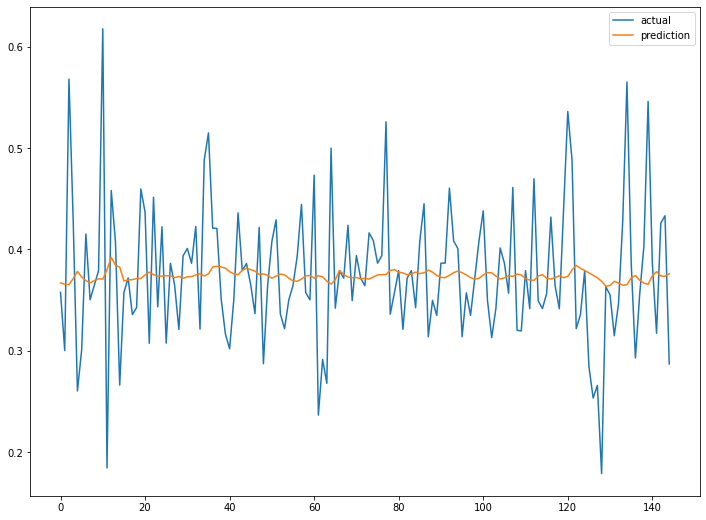

In [189]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [190]:
aa = pd.DataFrame(pred)

In [191]:
aa.columns = ['change']

In [192]:
aa['change'] = np.where(aa['change'] > 0,1,np.where(aa['change']==0,0,-1))

In [193]:
aa.change.value_counts()

1    145
Name: change, dtype: int64